In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as opj

from plancklens import utils

from delensalot.core import cachers

#from lenspyx.remapping import utils_geom as utils_scarf
#from delensalot.core.secondaries import secondaries

%reload_ext autoreload
%autoreload 2



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
import os
import numpy as np

import logging
log = logging.getLogger(__name__)
from logdecorator import log_on_start, log_on_end

alm2rlm = lambda x : x.copy()
rlm2alm = lambda x : x.copy()

#TODO this looks like a 'query' class to me. May be refactored.
class rec:
    """Static methods to reach for iterated lensing maps etc


    """

    @staticmethod
    def maxiterdone(lib_dir):
        lib_dir = os.path.abspath(lib_dir)
        itr = -2
        isdone = True
        while isdone:
            itr += 1
            isdone = rec.is_iter_done(lib_dir, itr + 1)
        return itr

    @staticmethod
    def load_plms(lib_dir, itrs, shift_1 = 0, shift_2 = 0):
        """Loads plms for the requested itrs"""
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        itmax = np.max(itrs)

        def get_shifted_name(shift_1, shift_2):
            stringa = ""
            if (shift_1 != 0) or (shift_2 != 0):
                stringa = '_%d_%d' % (shift_1, shift_2)
            return stringa

        sk_fname_ = lambda k: 'rlm_sn_%s_%s%s' % (k, 'p', get_shifted_name(shift_1, shift_2))
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', sk_fname_(k))
        #rlm = alm2rlm(cacher.load(os.path.join(lib_dir, f'phi_plm_it000{get_shifted_name(shift_1, shift_2)}')))
        rlm = alm2rlm(cacher.load(os.path.join(lib_dir, f'phi_plm_it000')))
        ret = [] if 0 not in itrs else [rlm2alm(rlm)]
        for i in range(itmax):
            if cacher.is_cached(sk_fname(i)):
                rlm += cacher.load(sk_fname(i))
                if (i + 1) in itrs:
                    ret.append(rlm2alm(rlm))
            else:
                log.info("*** Could only build up to itr number %s"%i)
                return ret
        return ret

    @staticmethod
    def load_elm(lib_dir, itr):
        """Load delensing E-map at iteration 'itr'

        """
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        e_fname = os.path.join(lib_dir, 'wflms', 'wflm_%s_it%s' % ('p', itr))
        assert cacher.is_cached(e_fname), 'cant load ' + e_fname
        return cacher.load(e_fname)

    @staticmethod
    def is_iter_done(lib_dir, itr):
        """Returns True if the iteration 'itr' has been performed already and False if not

        """
        lib_dir = os.path.abspath(lib_dir)
        if not os.path.exists(lib_dir): return False
        cacher = cachers.cacher_npy(lib_dir)
        if itr <= 0:
            return cacher.is_cached('%s_plm_it000' % ({'p': 'phi', 'o': 'om'}['p']))
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
        return cacher.is_cached(sk_fname(itr - 1))

    @staticmethod
    def load_grad(lib_dir, itr):
        #FIXME: load gradient at zero
        assert 0, 'fix gradient load at 0'
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        yk_fname = lambda k: os.path.join(lib_dir, 'hessian','rlm_yn_%s_%s' % (k, 'p'))
        rlm = alm2rlm(load_gradient(0, 'p'))
        for i in range(itr):
            rlm += cacher.load(yk_fname(i))
        return rlm2alm(rlm)

In [3]:
from plancklens import utils
from iterativefg import utils as itu

bin_edges = np.arange(10, 4000, 30)

def cross_corr_coeff(a, b, base = 0, color = None, plot = True, ax = None, label = None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: itu.bin_theory(x, bin_edges)
    el, x =  decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x**2/(aa*bb)
    if plot:
        if ax is None:
            plt.plot(el, xcorr-base, color = color, label = label)
        else:
            ax.plot(el, xcorr-base, color = color, label = label)
    return xcorr

def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

In [6]:
from os.path import join as opj
import os
from plancklens import utils


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'jointmap', 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]


##also, get some theory calculation for comparison
from plancklens import nhl, n0s, qresp

qe_key = "p_p"


SO_case = False
dir = "sodata/" if SO_case else ""

nlev_t = 1. if not SO_case else 6.
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = 1. if SO_case else 1.4
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = lmin_cmb, lmin_cmb, lmin_cmb
lmax_cmb = 4000
itermax = 1
ret_curl = True

lmax_qlm = 5120

lt, le, lb = (np.arange(lmax_cmb + 1) >= lmin_tlm), (np.arange(lmax_cmb + 1) >= lmin_elm), (np.arange(lmax_cmb + 1) >= lmin_blm)

transf = hp.gauss_beam(beam_fwhm / 180 / 60 * np.pi, lmax=lmax_cmb)
ftl = utils.cli(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
fel = utils.cli(cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
fbl = utils.cli(cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
fals = {'tt':ftl, 'ee':fel, 'bb':fbl}
dat_cls = {'tt':(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
            'ee': (cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
               'bb': (cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}

cls_ivfs_arr = utils.cls_dot([fals, dat_cls, fals])

cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

nggs = {}
r_ggs = {}
for source in ["p", "a"]:
    qe_key = f"{source}_p"

    GG_N0, CC_N0 = nhl.get_nhl(qe_key, qe_key, cls_len, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out = lmax_qlm)[0:2]

    r_gg_fid, r_cc_fid = qresp.get_response(qe_key, lmax_cmb, source, cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]

    n_gg = GG_N0 * utils.cli(r_gg_fid ** 2)

    nggs[source] = n_gg
    r_ggs[source] = r_gg_fid


from delensalot.biases import iterbiasesN0N1


qe_key = 'p_p'

cachedir = 'n0n1_cachedir_30' if not SO_case else 'n0n1_cachedir_30_SO'
itbias = iterbiasesN0N1.iterbiases(nlev_t, nlev_p, beam_fwhm, (30, lmin_cmb, lmin_cmb), lmax_cmb,
                                    lmax_qlm, cls_unl_fid, None, cachedir, verbose=True)
N0s_iter = {}
N1s_iter = {}
rggs_iter = {}
for itermax in [0, 10]:
    Ns, fid_delcls, dat_cls = itbias.get_n0n1(qe_key, itermax, None, None, version = "wN1")
    np.save(f"{dir}fid_delcls_{itermax}.npy", fid_delcls)
    N0s, N1s, rgg, _ = Ns
    N0s_iter[itermax] = N0s
    N1s_iter[itermax] = N1s
    rggs_iter[itermax] = rgg
    np.savetxt(f"N0s_{itermax}.txt", N0s)
    np.savetxt(f"N1s_{itermax}.txt", N1s)

lmin_tlm:30, lmin_elm:30, lmin_blm:30
Filtering with gaussian beam and fiducial noise levels
Adding n1 in iterations
 [00:00:07]  > 00%
Adding n1 in iterations
 [00:01:06]  ---------> 90%


In [5]:
ell = np.arange(0, len(cls_unl["tt"])+1)
ACB = 7
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(1)
cls_alpha[0] = 0
cls_alpha = cls_alpha[:5001]

/tmp/ipykernel_1410446/1975280843.py:3: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(1)


In [10]:
alpha = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_v2/simswalpha/sim_0000_alpha_lm.fits")
alpha_sim = utils.alm_copy(alpha, lmax = 5000)
alpha = hp.alm2cl(alpha_sim)

In [8]:
np.savetxt("alpha_sim.txt", alpha)

In [74]:
alpha_orig = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new/simswalpha/sim_0000_alpha_lm.fits")
alpha_orig = utils.alm_copy(alpha_orig, lmax = 5000)
alpha_orig = hp.alm2cl(alpha_orig)

In [75]:
mean = 0
NN = 40
indxs = range(NN) #list(range(NN))#+list(range())
counter = 0

for i in indxs:
    directory_i = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apo_new_official_check_factor_2_recs/p_p_sim{i:04}apo_new_official_check_factor_2/"
    alm_i = np.load(directory_i+almfile)
    for j in range(i+1, NN):
        directory_j = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apo_new_official_check_factor_2_recs/p_p_sim{j:04}apo_new_official_check_factor_2/"
        almfile = "alm0_norm.npy"
        #if os.path.exists(directory_i+almfile) and os.path.exists(directory_j+almfile):
        alm_j = np.load(directory_j+almfile)
        mean += hp.alm2cl(alm_i, alm_j)
        counter += 1

mean /= counter

#itrs = [0, 1, 2]
#rec.load_plms(directory, itrs)

In [15]:
from delensalot.core.iterator import statics
i = 0
plms = statics.rec().load_plms(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_v2_version_apo_new_official_check_factor_2_v2_recs/p_p_sim0000apo_new_official_check_factor_2_v2/", itrs = [0, 15])

In [16]:
qe = np.split(plms[0], 3)[0]
itr = np.split(plms[-1], 3)[0]

In [17]:
np.savetxt("qe.txt", np.c_[hp.alm2cl(qe), hp.alm2cl(qe, alpha_sim)])
np.savetxt("itr.txt", np.c_[hp.alm2cl(itr), hp.alm2cl(itr, alpha_sim)])

In [76]:
counter

780

In [114]:
final_mean = np.loadtxt("/home/users/d/darwish/scratch/final_mean.txt")
final_mean_64 = np.loadtxt("/home/users/d/darwish/scratch/final_mean_128.txt")
final_mean_264 = np.loadtxt("/home/users/d/darwish/scratch/final_mean_264.txt")

In [115]:

bin_edges = np.arange(10, 4000, 30)
bin_edges = np.append(np.arange(1, 20, 2), np.logspace(np.log10(20), 3.5, 100))

el, x = itu.bin_theory(final_mean, bin_edges)
el, a = itu.bin_theory(alpha, bin_edges)

el, x2 = itu.bin_theory(final_mean_264, bin_edges)

el, x64 = itu.bin_theory(final_mean_64, bin_edges)

In [116]:

el, x_o = itu.bin_theory(mean, bin_edges)
el, a_o = itu.bin_theory(alpha_orig, bin_edges)

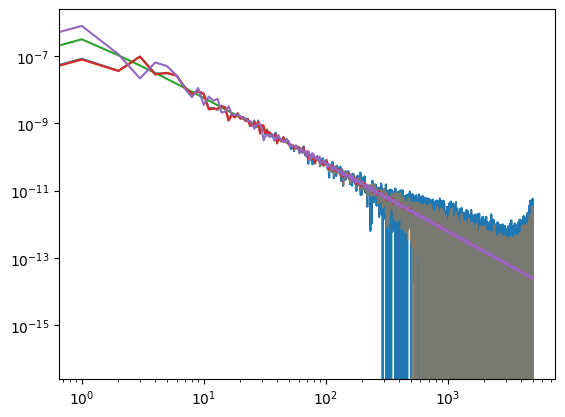

In [117]:
#plt.loglog(final_mean)
plt.plot(final_mean_64)
plt.loglog(final_mean_264, alpha = 0.4)

plt.plot(cls_alpha)
plt.plot(alpha)


#plt.loglog(mean, alpha = 0.3)
plt.plot(alpha_orig)

In [1]:
alpha

NameError: name 'alpha' is not defined

'plt.loglog(el, x_o)\nplt.plot(el, a_o)'

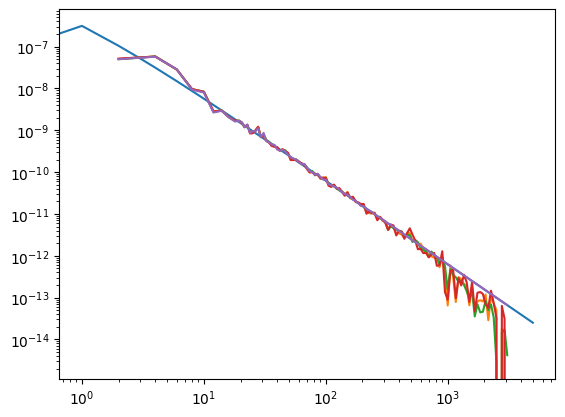

In [118]:
plt.plot(cls_alpha)

plt.loglog(el, x)
plt.loglog(el, x2)
plt.loglog(el, x64)
plt.plot(el, a)

"""plt.loglog(el, x_o)
plt.plot(el, a_o)"""

/tmp/ipykernel_2426703/2861753112.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(el, np.sqrt(x64/a))
/tmp/ipykernel_2426703/2861753112.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(el, np.sqrt(x2/a))


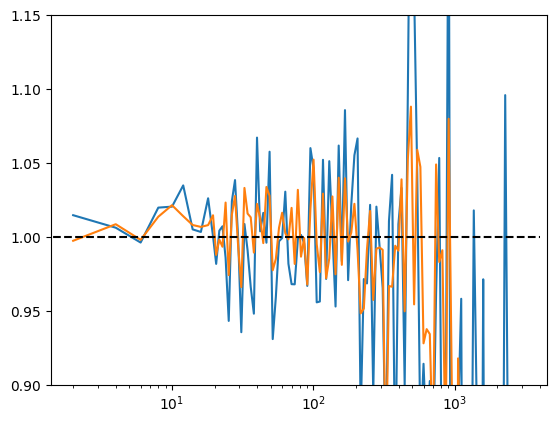

In [119]:
#plt.plot(np.sqrt(final_mean/alpha))

plt.plot(el, np.sqrt(x64/a))
plt.plot(el, np.sqrt(x2/a))
#plt.plot(el, np.sqrt(x_o/a_o))

plt.ylim(0.9, 1.15)
plt.xscale("log")
plt.hlines(1, 1, 4000, ls = "--", color = "black")

In [ ]:
final_mean_64 = np.loadtxt("/home/users/d/darwish/scratch/final_mean_64.txt")
final_mean_64 = np.loadtxt("/home/users/d/darwish/scratch/final_mean_64.txt")


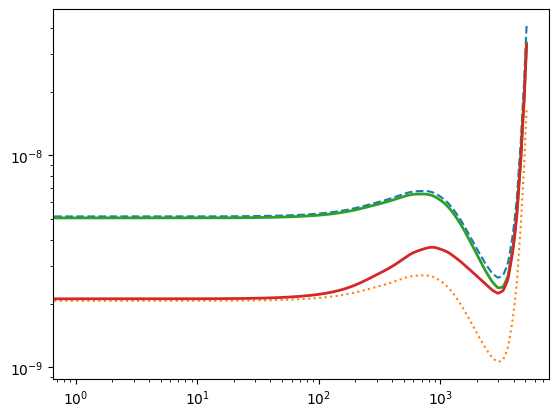

In [11]:
plt.loglog(nggs["a"], ls = "--")

plt.loglog(nggs["a"]/2.5, ls = ":")

dir = "s4data/"

source = "a"
qe_key = f"{source}_p"

it = 0
fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

n_gg = nhl.get_nhl(qe_key, qe_key, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[0]
r_gg_true = qresp.get_response(qe_key, lmax_cmb, source, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0]
N0_unbiased = n_gg * utils.cli(r_gg_true ** 2)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
plt.loglog(N0_unbiased, lw = 2)
#np.savetxt(f"{dir}/ngg_a_itr_1.txt", N0_unbiased)

it = 10
fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]
n_gg = nhl.get_nhl(qe_key, qe_key, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[0]
r_gg_true = qresp.get_response(qe_key, lmax_cmb, source, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0]
N0_unbiased = n_gg * utils.cli(r_gg_true ** 2)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
plt.loglog(N0_unbiased, lw = 2)
#np.savetxt(f"{dir}/ngg_a_itr_10.txt", N0_unbiased)


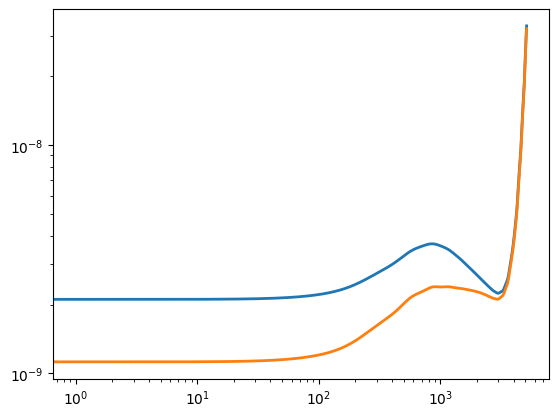

In [5]:
plt.loglog(N0_unbiased, lw = 2)


ftl = utils.cli(cls_unl['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
fel = utils.cli(cls_unl['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
fbl = utils.cli(cls_unl['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
fal = {'tt':ftl, 'ee':fel, 'bb':fbl}

dat_delcls = {'tt':(cls_unl['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
            'ee': (cls_unl['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
               'bb': (cls_unl['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}


cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

n_gg = nhl.get_nhl(qe_key, qe_key, cls_unl, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[0]
r_gg_true = qresp.get_response(qe_key, lmax_cmb, source, cls_w, cls_unl, fal, lmax_qlm=lmax_qlm)[0]
N0_unbiased = n_gg * utils.cli(r_gg_true ** 2)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
plt.loglog(N0_unbiased, lw = 2)
np.savetxt("ngg_a_itr_unl.txt", N0_unbiased)

In [23]:
5*1e-9/(4.5e-10)

11.11111111111111

In [9]:
from plancklens.n1 import n1

lib_dir = './n1s_ranks'
n1lib = n1.library_n1(lib_dir, cls_len['tt'], cls_len['te'], cls_len['ee'], lmaxphi=2500, dL=10, lps=None)
n1_aa = n1lib.get_n1('a_p', 'a', cls_unl['pp'], ftl, fel, fbl, lmax_qlm)*utils.cli(r_ggs["a"] ** 2)#note, should be 'aa' not 'pp'!!
n1_ap = n1lib.get_n1('a_p', 'p', cls_unl['pp'], ftl, fel, fbl, lmax_qlm)*utils.cli(r_ggs["a"] ** 2)
#n1_pp = n1lib.get_n1('p_p', 'p', cls_unl['pp'], ftl, fel, fbl, lmax_qlm)

/users/odarwish/pythonpackages/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


n1: rank 0 doing L 1 kA aee kB aee kind a
n1: rank 0 doing L 2 kA aee kB aee kind a
n1: rank 0 doing L 3 kA aee kB aee kind a


KeyboardInterrupt: 

In [6]:
out_dir = "noise_biases/"
n_gg = np.loadtxt(out_dir+"ngg_a_QE.txt") #GG_N0 * utils.cli(r_gg_fid ** 2)
n1_ap = np.loadtxt(out_dir+"n1_ap_QE.txt")
n1_aa = np.loadtxt(out_dir+"n1_aa_QE.txt")

n1_ap_itr = np.loadtxt(out_dir+"n1_ap_itr_10.txt")
n1_aa_itr = np.loadtxt(out_dir+"n1_aa_itr_10.txt")

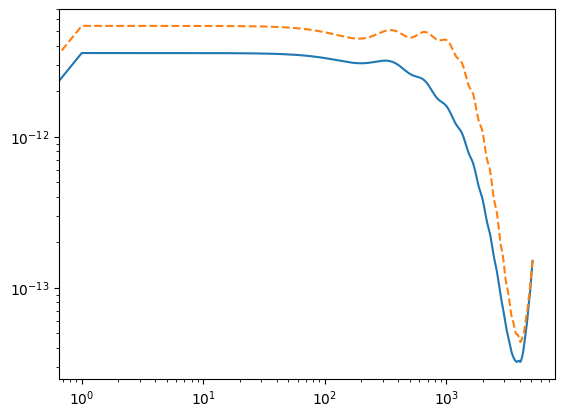

In [9]:
plt.loglog(n1_aa)
plt.loglog(n1_aa_itr, ls = "--")

In [11]:
np.savetxt("n1_ap_QE.txt", n1_ap)
np.savetxt("n1_aa_QE.txt", n1_aa)

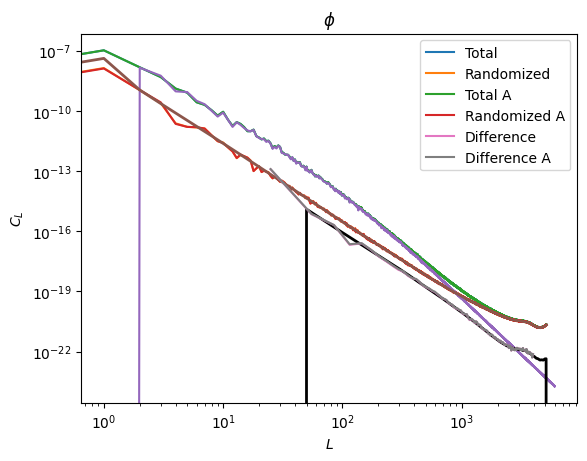

In [8]:
plt.title(r"$\phi$")

dir = "/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim0099test_randomizing_new/"
plm0 = np.load(dir + "plm0_norm.npy")
plm0_11 = np.load(dir + "plm0_11_norm.npy")
plm0_22 = np.load(dir + "plm0_22_norm.npy")
plm = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new/simswalpha/sim_0099_plm.fits")

vv = "test_randomizing_alpha_new_low_ell"
#vv = "test_randomizing_alpha_new"
dir = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_alpha_new_version_{vv}_recs/p_p_sim0099{vv}/"
plm0a = np.load(dir + "plm0_norm.npy")
plm0_11a = np.load(dir + "plm0_11_norm.npy")
plma = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_alpha_new/simswalpha/sim_0099_plm.fits")


cltot = hp.alm2cl(plm0)
plt.loglog(cltot, label = "Total")
N0_rand = hp.alm2cl(plm0_11)#*0.5
plt.loglog(N0_rand, label = "Randomized")

cltota = hp.alm2cl(plm0)
plt.loglog(cltota, label = "Total A")
N0_randa = hp.alm2cl(plm0_11a)#*0.5
plt.loglog(N0_randa, label = "Randomized A")

#other = hp.alm2cl(plm0_11)
#plt.plot(other, ls = "--")

input = hp.alm2cl(plm)
inputa = hp.alm2cl(plma)
plt.loglog(input)
plt.plot(nggs["p"], lw = 2)

plt.plot(N1s_iter[0], lw = 2, color = "black")

difference = cltot-N0_rand-input[:5121]
el, x = itu.bin_theory(difference, bin_edges)
plt.plot(el, x, label = "Difference")

difference = cltota-N0_randa-inputa[:5121]
el, x = itu.bin_theory(difference, bin_edges)
plt.plot(el, x, label = "Difference A")

plt.xlabel("$L$")
plt.ylabel("$C_L$")
plt.legend()

#plt.savefig("/users/odarwish/JointCMBiterative/figures/examples/N0_QE_phi_subtraction.pdf", dpi = 300)

In [10]:
color_palette = [
    "#377eb8",  # Blue
    "#ff7f00",  # Orange
    "#4daf4a",  # Green
    "#f781bf",  # Pink
    "#a65628",  # Brown
    "#984ea3",  # Purple
    "#999999",  # Grey
    "#e41a1c",  # Red
    "#dede00"   # Yellow
]

In [91]:
dir = "/users/odarwish/scratch/joint_map_outputs/"
qe_auto = np.load(dir+"total_qe_p_p_apo_new_official_apo_new_0_127_20.npy")
input = np.load(dir+"input_apo_new_official_a_disabled_apo_new_0_127_20.npy")

input_split = input[:, 0, :]
input_mean = np.split(input.mean(axis = 0), 3)[0].squeeze()
input_std = np.split(input.std(axis = 0), 3)[0].squeeze()
qe_auto_split = np.split(qe_auto, 3, axis = -1)

std = qe_auto_split[0].std(axis = 0)
mean = qe_auto_split[0].mean(axis = 0)

bin_edges = np.arange(1, 4000, 10)

bin = lambda x: itu.bin_theory(x, bin_edges)[-1]
qe_auto_binned = np.apply_along_axis(bin, -1, qe_auto_split[0])
std_binned = qe_auto_binned.std(axis = 0)
mean_binned = qe_auto_binned.mean(axis = 0)

std_mean_binned = np.apply_along_axis(bin, -1, input_split).std(axis = 0)

deltal = bin_edges[1] - bin_edges[0]
el = itu.bin_theory(mean, bin_edges)[0]



gauss_err = np.sqrt(1/(2*el+1)/deltal*2*(mean_binned)**2)




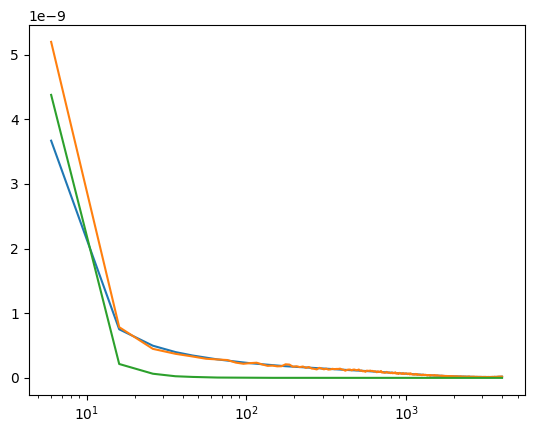

In [92]:
plt.plot(el, gauss_err)
plt.plot(el, std_binned)
plt.plot(el, std_mean_binned)
plt.xscale("log")

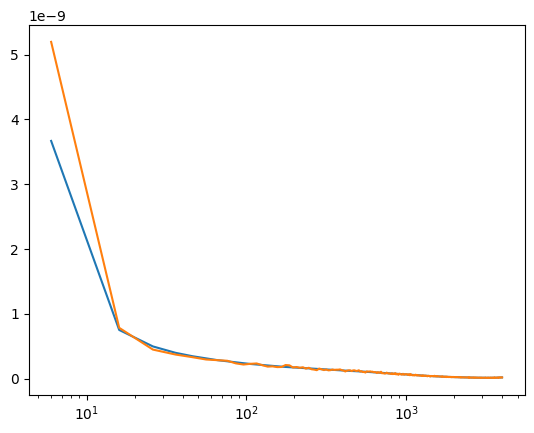

In [94]:
plt.plot(el, gauss_err)
plt.plot(el, std_binned)
plt.xscale("log")

(5, 100)

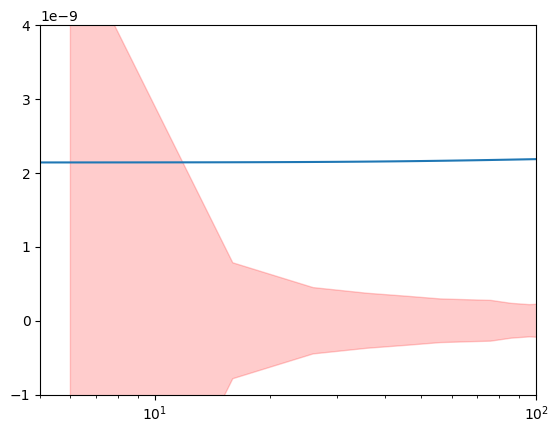

In [162]:
input = hp.alm2cl(alpha)
el, input_binned = itu.bin_theory(input, bin_edges)

#plt.plot(input)
#plt.errorbar(el, input_binned, yerr = gauss_err, fmt = "o", color = "red")

plt.fill_between(el, 0-std_binned, 0+std_binned, alpha = 0.2, color = "red")
#plt.fill_between(np.arange(len(std)), 0-std, 0+std, alpha = 0.2, color = "red")

plt.plot(n1_ap)
#plt.plot(n1_ap_itr)
plt.xscale("log")
#plt.yscale("log")

plt.ylim(-1e-9, 4e-9)
plt.xlim(5, 100)

In [208]:
NN = 1
mean_i = 0
mean_i_rand = 0
mean_j = 0
mean_alpha = 0

for i in range(NN):

    ii = 12
    ii = i

    cmbversion = "apo_new"
    version = "apo_new_official_a_disabled"

    cmbversion = "alpha_after_lensing_sims"
    version = "alpha_after_lensing_sims"
    
    dir = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/{cmbversion}_version_{version}_recs/p_p_sim{ii:04}{version}/"
    plm0_i = np.load(dir + "alm0_norm.npy")

    plm0_i_rand = np.load(dir + "alm0_11_norm.npy")

    alpha = hp.read_alm(f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_omega_cmb/simswalpha/sim_{ii:04}_alpha_lm.fits")
    alpha = utils.alm_copy(alpha, 5000)
    mean_alpha += hp.alm2cl(alpha)

    dir = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/po_new_version_po_new_official_a_disabled_recs/p_p_sim{ii:04}po_new_official_a_disabled/"
    plm0_j = np.load(dir + "alm0_norm.npy")

    mean_i += hp.alm2cl(plm0_i)
    mean_j += hp.alm2cl(plm0_j)
    mean_i_rand += hp.alm2cl(plm0_i_rand)

mean_i /= NN
mean_i_rand /= NN
mean_j /= NN
mean_alpha /= NN


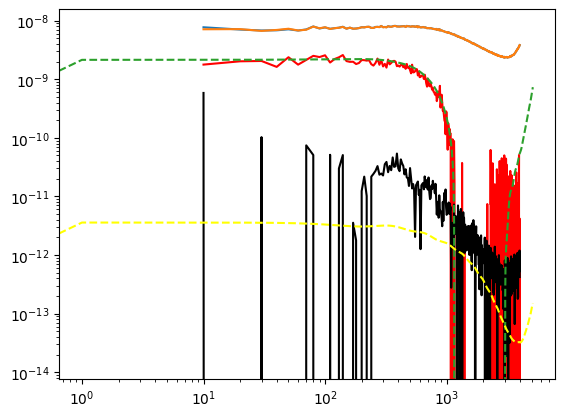

In [212]:
bin_edges = np.arange(5, 4000, 10)

el, meanb_i = itu.bin_theory(mean_i, bin_edges)
el, meanb_i_rand = itu.bin_theory(mean_i_rand, bin_edges)
el, meana = itu.bin_theory(mean_alpha, bin_edges)
plt.plot(el, meanb_i-meana)
#plt.plot(el, meana)

el, meanb_j = itu.bin_theory(mean_j, bin_edges)
plt.plot(el, meanb_j)

plt.plot(el, meanb_j-meanb_i_rand, color = "red")

#plt.plot(el, meanb_j-meanb_i-meana, color = "orange")


plt.plot(el, (meanb_i-meana-meanb_j), color = "black")

el, mean_rand = itu.bin_theory(N0_rand, bin_edges)
#plt.plot(el, meanb_j-mean_rand)

#plt.plot(nggs["a"])

plt.plot(n1_ap, ls = "--")

out_dir = "noise_biases/"
n_gg = np.loadtxt(out_dir+"ngg_a_QE.txt")
n1_ap = np.loadtxt(out_dir+"n1_ap_QE.txt")
n1_aa = np.loadtxt(out_dir+"n1_aa_QE.txt")

plt.plot(n1_aa, ls = "--", color = "yellow")

plt.xscale("log")
plt.yscale("log")

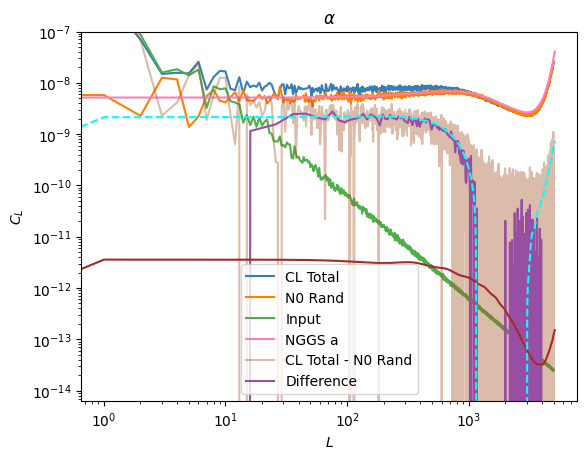

In [117]:
plt.title(r"$\alpha$")

alpha = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_omega_cmb/simswalpha/sim_0012_alpha_lm.fits")
alpha = utils.alm_copy(alpha, 5000)
input = hp.alm2cl(alpha)

dir = "/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_omega_cmb_version_alpha_disabled_phi_omega_randomized_tests_recs/p_p_sim0012alpha_disabled_phi_omega_randomized_tests/"
plm0 = np.load(dir + "alm0_norm.npy")
plm0_12 = np.load(dir + "alm0_11_norm.npy")

plm0WF = np.load(dir + "phi_plm_it000.npy")
x = np.split(plm0WF, 3)[0]
cross = hp.alm2cl(x, alpha)
corr = np.loadtxt("corr.txt")
correction = corr
cl_auto = hp.alm2cl(x)*correction**2.

#plt.plot(cl_auto, color = "green", alpha = 0.4)

el, x = np.loadtxt("x.txt").T
#plt.plot(el, x, lw = 2, color = "red")

el, x = np.loadtxt("xrand.txt").T
#plt.plot(el, x, lw = 2, ls = "--", color = "red")

# Perform calculations
n_gg = GG_N0 * utils.cli(r_gg_fid ** 2)
cltot = hp.alm2cl(plm0)
plt.loglog(cltot, label="CL Total", color=color_palette[0])
N0_rand = hp.alm2cl(plm0_12)
plt.loglog(N0_rand, label="N0 Rand", color=color_palette[1])
plt.loglog(input, label="Input", color=color_palette[2])
plt.plot(nggs["a"], label="NGGS a", color=color_palette[3])
plt.plot(cltot - N0_rand, label="CL Total - N0 Rand", color=color_palette[4], alpha = 0.4)

# Calculate difference and bin
difference = cltot - N0_rand - input[:5001]
el, x = itu.bin_theory(difference, bin_edges)
plt.plot(el, x, label="Difference", color=color_palette[5])

#plt.plot(el, el*0+4.01177468e-09, color = "black")

plt.loglog(n1_aa, color = "brown")
plt.loglog(n1_ap, color = "cyan", ls = "--")

# Add labels and legend
plt.ylabel("$C_L$")
plt.xlabel("$L$")
plt.legend()

plt.ylim(ymax = 1e-7)
plt.savefig("/users/odarwish/JointCMBiterative/figures/examples/N0_QE_alpha_subtraction.pdf", dpi=300)

# Display the plot
plt.show()


In [11]:
import sys
path_to_tempura = "/users/odarwish/tempura/" # please change this path
sys.path.append(path_to_tempura) # example
import pytempura as cs

Tcmb  = 2.726e6    # CMB temperature
Lmax  = 5000       # maximum multipole of output normalization
lmax  = 4000
rlmin, rlmax = 20, 4000  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
l = L.copy()
Lfac = (L*(L+1.))**2/(2*np.pi)

lcl = np.zeros((4,lmax+1)) # TT, EE, BB, TE
lcl[0, :] = cls_len["tt"][:lmax+1]
lcl[1, :] = cls_len["ee"][:lmax+1]
lcl[2, :] = cls_len["bb"][:lmax+1]
lcl[3, :] = cls_len["te"][:lmax+1]

ocl = lcl*1. # observed Cl (here, no CMB noise)

ocl = lcl.copy()
ocl[0] += (nlev_t / 60. / 180. * np.pi) ** 2 / transf[:lmax+1] ** 2
ocl[1] += (nlev_p / 60. / 180. * np.pi) ** 2 / transf[:lmax+1] ** 2
ocl[2] += (nlev_p / 60. / 180. * np.pi) ** 2 / transf[:lmax+1] ** 2

QDO = [False,False,True,False,True,False]
Ar = cs.norm_general.qall('rot',QDO,Lmax,rlmin,rlmax,lcl,lcl,ocl)[0]

 norm qMV
 norm qMV


In [12]:
clbb = 0
clee = 0
NNN = 16
for i in range(NNN):
    blm = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/"+"sim_0014_blm.fits")
    elm = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/"+"sim_0014_elm.fits")
    clbb += hp.alm2cl(blm)
    clee += hp.alm2cl(elm)

clbb /= NNN
clee /= NNN

In [15]:
cls_rot = {k: cls_len[k] for k in cls_len.keys()}
cls_rot["bb"] = clbb
cls_rot["ee"] = clee

In [18]:
r_gg_fida_grad, r_cc_fid = qresp.get_response("a_p", lmax_cmb, 'a', cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]
r_gg_fida_lens, r_cc_fid = qresp.get_response("a_p", lmax_cmb, 'a', cls_len, cls_len, fals, lmax_qlm = lmax_qlm)[0:2]

np.savetxt("fac.txt", (r_gg_fida_grad**-1.)[:Ar[5].size]/Ar[5])
np.savetxt("norm.txt", (r_gg_fida_grad**-1.)[:Ar[5].size])

/tmp/ipykernel_16147/1033063089.py:4: RuntimeWarning: divide by zero encountered in divide
  np.savetxt("fac.txt", (r_gg_fida_grad**-1.)[:Ar[5].size]/Ar[5])


In [16]:
r_gg_fida_rot, r_cc_fid = qresp.get_response("a_p", lmax_cmb, 'a', cls_rot, cls_len, fals, lmax_qlm = lmax_qlm)[0:2]
r_gg_fida_rot2, r_cc_fid = qresp.get_response("a_p", lmax_cmb, 'a', cls_len, cls_rot, fals, lmax_qlm = lmax_qlm)[0:2]


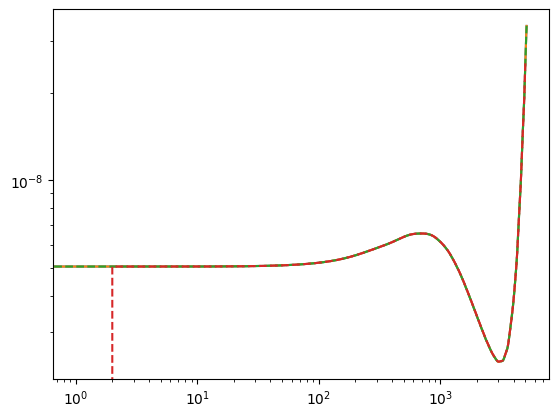

In [20]:
plt.loglog(r_gg_fida_rot**-1.)
plt.loglog(r_gg_fida_rot2**-1.)
plt.loglog(r_gg_fida_lens**-1., ls = "--")
plt.loglog(Ar[5], ls = "--")
#plt.loglog(Ar[4], ls = "--")

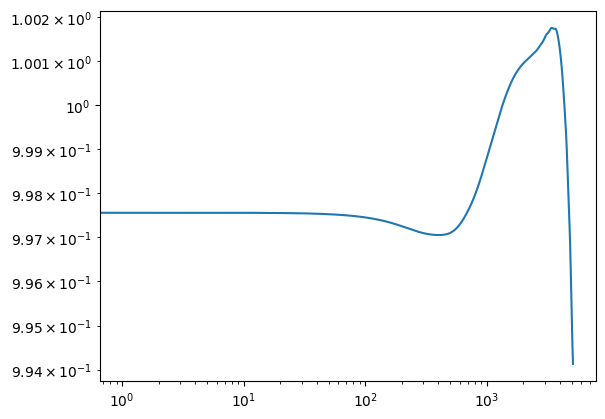

In [18]:
plt.loglog(r_gg_fida_grad/r_gg_fida_lens)

In [7]:
n1_aa

NameError: name 'n1_aa' is not defined

In [11]:
np.savetxt("n1_ap.txt", n1_ap)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim0099test_randomizing_new/hessian/rlm_sn_0_p_1000_2000.npy'

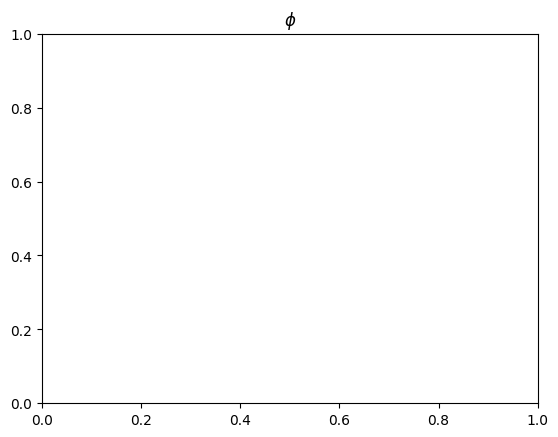

In [ ]:
plt.title(r"$\phi$")

dir = "/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim0099test_randomizing_new/"
plm0 = np.load(dir + "phi_plm_it000.npy")
plm0_12 = np.load(dir + "phi_plm_it000_1000_2000.npy")
plm0_21 = np.load(dir + "phi_plm_it000_2000_1000.npy")
#plm = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new/simswalpha/sim_0099_plm.fits")

Nfields = 2
p, o = np.split(plm0, Nfields)
p12, o12 = np.split(plm0_12, Nfields)
p21, o21 = np.split(plm0_21, Nfields)

delta0 = np.load(dir + "hessian/rlm_sn_0_p.npy")
delta0_12 = np.load(dir + "hessian/rlm_sn_0_p_1000_2000.npy")
delta0_21 = np.load(dir + "hessian/rlm_sn_0_p_2000_1000.npy")


#delta1 = np.load(dir + "hessian/rlm_sn_1_p.npy")
#delta1_12 = np.load(dir + "hessian/rlm_sn_1_p_1000_2000.npy")
#delta1_21 = np.load(dir + "hessian/rlm_sn_1_p_2000_1000.npy")


del plm0, plm0_12, plm0_21

deltap, deltao = np.split(delta0, Nfields)
deltap12, deltao12 = np.split(delta0_12, Nfields)
deltap21, deltao21 = np.split(delta0_21, Nfields)

#delta1p, delta1o = np.split(delta1, Nfields)
#delta1p12, delta1o12 = np.split(delta1_12, Nfields)
#delta1p21, delta1o21 = np.split(delta1_21, Nfields)

del delta0, delta0_12, delta0_21
#del delta1, delta1_12, delta1_21

p_1 = p + deltap + delta1p
p12_1 = p12 + deltap12
p21_1 = p21 + deltap21


cltot = hp.alm2cl(p)
plt.loglog(cltot, label = "Total")
N0_rand = hp.alm2cl(p12+p21)*0.5
plt.loglog(cltot-N0_rand, label = "Randomized 0")

cltot = hp.alm2cl(p_1)
plt.loglog(cltot, label = "Total 1", ls = "--")
N0_rand = hp.alm2cl(p12_1+p21_1)*0.5
plt.loglog(cltot-N0_rand, label = "Randomized 1")


input = hp.alm2cl(plm)
plt.loglog(input, label = "Signal")

plm = utils.alm_copy(plm, lmax = hp.Alm.getlmax(len(p)))
cross = hp.alm2cl(plm, p_1)
input = hp.alm2cl(plm)
norm = input/cross

N0_rand_norm = N0_rand*norm**2

#plt.loglog(N0_rand_norm, label = "Randomized 1 normalized")

#plt.plot(nggs["p"], lw = 2, label = "N0 QE norm")

#plt.plot(N0s_iter[1], label = "N0 iter 1", ls = "--")

#plt.plot(N1s_iter[0], lw = 2, color = "black")

#difference = cltot-N0_rand-input[:5121]

#el, x = itu.bin_theory(difference, bin_edges)
#plt.plot(el, x, label = "Difference")

plt.xlabel("$L$")
plt.ylabel("$C_L$")
plt.legend()

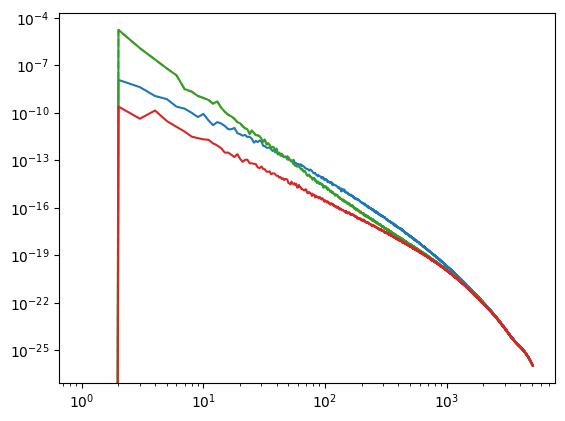

In [34]:
plt.loglog(hp.alm2cl(p))
plt.loglog(hp.alm2cl(p12), ls = "--")
plt.loglog(hp.alm2cl(p21), ls = "-")
plt.loglog(hp.alm2cl(p12+p21)*0.5)


In [12]:
glm0 = np.load(dir + "plm_gradplik_it000.npy")
glm0_01 = np.load(dir + "plm_gradplik_it000_0_1.npy")
glm0_10 = np.load(dir + "plm_gradplik_it000_1_0.npy")
glm0_11 = np.load(dir + "plm_gradplik_it000_1_1.npy")
glm0_12 = np.load(dir + "plm_gradplik_it000_0_1.npy")
glm0_21 = np.load(dir + "plm_gradplik_it000_1_0.npy")
glm0_22 = np.load(dir + "plm_gradplik_it000_2_2.npy")

glm0 = np.split(glm0, 2)[0]
glm0_01 = np.split(glm0_01, 2)[0]
glm0_10 = np.split(glm0_10, 2)[0]
glm0_11 = np.split(glm0_11, 2)[0]
glm0_12 = np.split(glm0_12, 2)[0]
glm0_21 = np.split(glm0_21, 2)[0]
glm0_22 = np.split(glm0_22, 2)[0]

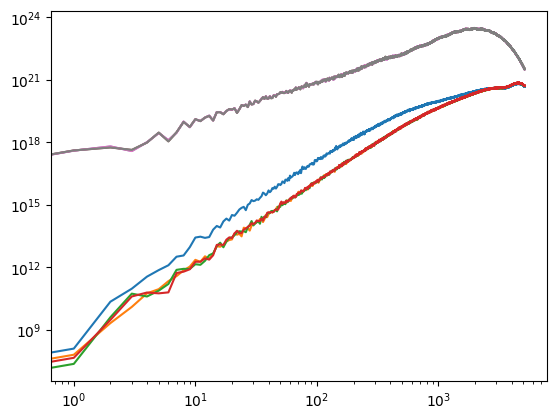

In [25]:
plt.loglog(hp.alm2cl(glm0))

plt.loglog(hp.alm2cl(glm0_11))
plt.loglog(hp.alm2cl(glm0_22))
plt.loglog(hp.alm2cl(glm0_11+glm0_22)*0.5)

plt.loglog(hp.alm2cl(glm0_01))
plt.loglog(hp.alm2cl(glm0_10))

plt.loglog(hp.alm2cl(glm0_12))
plt.loglog(hp.alm2cl(glm0_21))

/tmp/ipykernel_7445/2172020928.py:7: RuntimeWarning: invalid value encountered in divide
  norm1 = ii/ac1
/tmp/ipykernel_7445/2172020928.py:8: RuntimeWarning: invalid value encountered in divide
  norm = ii/ac
/tmp/ipykernel_7445/2172020928.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(ac**2/(a*ii))
/tmp/ipykernel_7445/2172020928.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(ac1**2/(a1*ii))


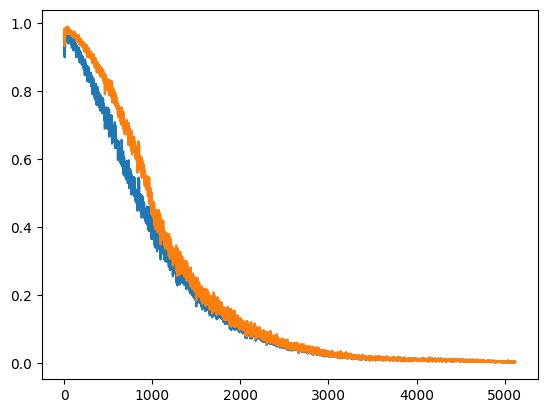

In [53]:
a1 = hp.alm2cl(p_1)
a = hp.alm2cl(p)
ac1 = hp.alm2cl(p_1, plm)
ac = hp.alm2cl(p, plm)
ii = hp.alm2cl(plm, plm)

norm1 = ii/ac1
norm = ii/ac

plt.plot(ac**2/(a*ii))
plt.plot(ac1**2/(a1*ii))

In [51]:
from lenspyx.remapping.deflection_028 import rtype, ctype

In [ ]:
ctype

## $\phi,\omega$, no $\tau,\alpha$




In [120]:
directory = "/users/odarwish/scratch/joint_map_outputs/"

cmbversion = "phi_new"
version = "phi_omega_new_joint_grad"

rand_cmbversion = "phi_new"
rand_version = "phi_omega_new_joint_grad_randomized"

############################################################

cmbversion = "test_3"
version = "test_3_low_lmax"

rand_cmbversion = "test_3"
rand_version = "test_3_low_lmax_randomized"

itmax = 0
imin = 0
imax = 31

qe_key = "p_p"

input_spectra = np.load(directory + f"input_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy")
input_spectra_mean = input_spectra.mean(axis=0)
phi_input, omega_input = input_spectra_mean

total_qe = np.load(directory + f"total_qe_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy")
total_qe_cross = np.load(directory + f"total_qe_cross_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy")

total_qe_rand = np.load(directory + f"total_qe_{qe_key}_{rand_version}_{rand_cmbversion}_{imin}_{imax}_{itmax}.npy")
total_qe_cross_rand = np.load(directory + f"total_qe_cross_{qe_key}_{rand_version}_{rand_cmbversion}_{imin}_{imax}_{itmax}.npy")

total_qe_mean = total_qe.mean(axis = 0)
total_qe_cross_mean = total_qe_cross.mean(axis = 0)

total_qe_rand_mean = total_qe_rand.mean(axis = 0)
total_qe_cross_rand_mean = total_qe_cross_rand.mean(axis = 0)

difference = total_qe_mean - total_qe_rand_mean

In [135]:
##also, get some theory calculation for comparison
from plancklens import nhl, n0s, qresp

qe_key = "p_p"
nlev_t = 1.
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = 1.
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = 200, lmin_cmb, lmin_cmb
lmax_cmb = 3000
itermax = itmax+1
ret_curl = True

lmax_qlm = 5120

In [137]:
result = nhl.get_N0_iter(qe_key, nlev_t, nlev_p, beam_fwhm, cls_unl_fid, lmin_cmb, lmax_cmb, itermax, lmax_qlm = lmax_qlm, version = "wN1")

Adding n1 in iterations
 [00:01:32]  -----> 50%


In [9]:
n0s_result = n0s.get_N0(beam_fwhm, nlev_t, nlev_p, lmax_cmb,
           {'t':lmin_tlm, 'e':lmin_elm, 'b':lmin_blm}, lmax_qlm,
           cls_len,
           cls_grad,
           cls_len,
           joint_TP = False, ksource = 'p')

Seeing lmin's:
t: 30
e: 30
b: 200


In [ ]:
##also, get some theory calculation for comparison
from plancklens import nhl, n0s, qresp

qe_key = "p_p"
nlev_t = 1.
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = 1.
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = 200, lmin_cmb, lmin_cmb
lmax_cmb = 3000
itermax = itmax+1
ret_curl = True

lmax_qlm = 5120

lt, le, lb = (np.arange(lmax_cmb + 1) >= lmin_tlm), (np.arange(lmax_cmb + 1) >= lmin_elm), (np.arange(lmax_cmb + 1) >= lmin_blm)

transf = hp.gauss_beam(beam_fwhm / 180 / 60 * np.pi, lmax=lmax_cmb)
ftl = utils.cli(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
fel = utils.cli(cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
fbl = utils.cli(cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
fals = {'tt':ftl, 'ee':fel, 'bb':fbl}
dat_cls = {'tt':(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
            'ee': (cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
               'bb': (cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}

cls_ivfs_arr = utils.cls_dot([fals, dat_cls, fals])

cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

GG_N0, CC_N0 = nhl.get_nhl(qe_key, qe_key, cls_len, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out = lmax_qlm)[0:2]

r_gg_fid, r_cc_fid = qresp.get_response(qe_key, lmax_cmb, 'p', cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]

In [140]:
r_gg_fid, r_cc_fid = qresp.get_response(qe_key, lmax_cmb, 'p', cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]

In [141]:
r_gg_fid_2, _ = qresp.get_response(qe_key, lmax_cmb, 'p', cls_len, cls_len, fals, lmax_qlm = lmax_qlm)[0:2]

In [142]:
r_gg_fid_3, _ = qresp.get_response(qe_key, lmax_cmb, 'p', cls_grad, cls_len, fals, lmax_qlm = lmax_qlm)[0:2]

In [143]:
n_gg = GG_N0 * utils.cli(r_gg_fid ** 2)
n_cc = CC_N0 * utils.cli(r_cc_fid ** 2)
n_gg_len = GG_N0 * utils.cli(r_gg_fid_2 ** 2)

In [144]:
N0s, N0_curls = n0s_result
N0s = N0s["p_p"]
N0_curls = N0_curls["p_p"]

In [145]:
N0s_iter, N1s_iter = result[0], result[2]

/tmp/ipykernel_14881/1879524685.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(N0s/n_gg, ls = "--")
/tmp/ipykernel_14881/1879524685.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(N0s_iter[0]/n_gg)


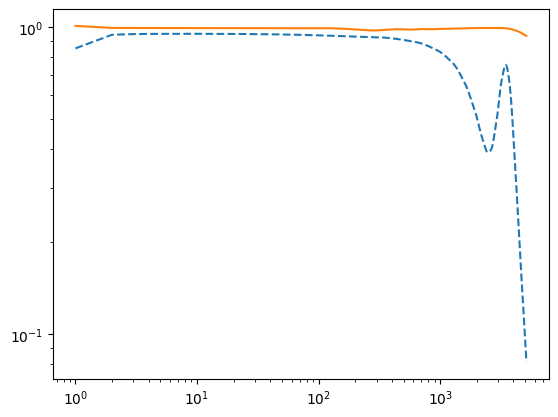

In [146]:
#plt.loglog(N0s_iter[0], ls = ":")
plt.loglog(N0s/n_gg, ls = "--")
plt.plot(N0s_iter[0]/n_gg)

In [147]:
def randomizing_fg(seed: int = 0, shape = (10,)):
     np.random.seed(seed)
     return np.exp(1j*np.random.uniform(0., 2.*np.pi, size = shape))

In [148]:
print(randomizing_fg(0))
print(randomizing_fg(0))

[-0.95333378-0.30191837j -0.21698192-0.97617562j -0.79868996-0.60174275j
 -0.9604982 -0.27828619j -0.88713755+0.46150511j -0.60845841-0.79358576j
 -0.92408909+0.38217712j  0.77756625-0.62880103j  0.97404947-0.22633522j
 -0.74359949+0.6686253j ]
[-0.95333378-0.30191837j -0.21698192-0.97617562j -0.79868996-0.60174275j
 -0.9604982 -0.27828619j -0.88713755+0.46150511j -0.60845841-0.79358576j
 -0.92408909+0.38217712j  0.77756625-0.62880103j  0.97404947-0.22633522j
 -0.74359949+0.6686253j ]


/tmp/ipykernel_14881/2782214727.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(np.split(total_qe_rand_mean, 2)[0]/n_gg, lw = 2)


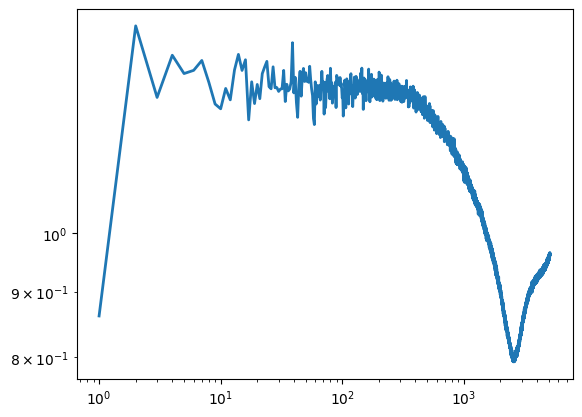

In [149]:
plt.loglog(np.split(total_qe_rand_mean, 2)[0]/n_gg, lw = 2)

In [22]:
from plancklens.n1 import n1

lib_dir = './n1_tests'
n1lib = n1.library_n1(lib_dir, cls_len['tt'], cls_len['te'], cls_len['ee'], lmaxphi=lmax_qlm, dL=10, lps=None)
n1_pp = n1lib.get_n1('p_p', 'p', cls_unl['pp'], ftl, fel, fbl, lmax_qlm)

/users/odarwish/pythonpackages/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


In [23]:
N1 = n1_pp * utils.cli(r_gg_fid) ** 2

In [126]:
Nf = 2

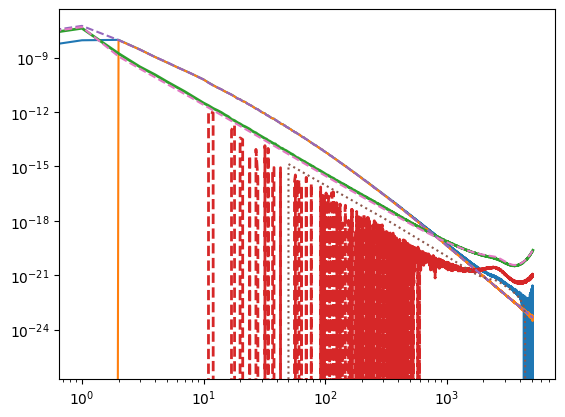

In [158]:
plt.loglog(np.split(total_qe_mean, Nf)[0]-n_gg)

plt.loglog(np.split(total_qe_cross_mean, Nf)[0])

plt.loglog(np.split(total_qe_rand_mean, Nf)[0], lw = 2)

plt.plot(np.split(difference, Nf)[0]-phi_input, lw = 2, ls = "--")

plt.plot(phi_input, ls = "--")

#plt.loglog(np.split(total_qe_cross_rand_mean, 2)[0])

plt.plot(N1s_iter[0], ls = ":")

#plt.plot(N1, ls = "--")

plt.loglog(n_gg, ls = "--")

#plt.plot(N1s_iter[0]+N0s_iter[0]+phi_input)

/tmp/ipykernel_14881/3908605529.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot((np.split(total_qe_mean, Nf)[0]-n_gg-N1s_iter[0])/phi_input, alpha = 0.1)


(20.0, 3000.0)

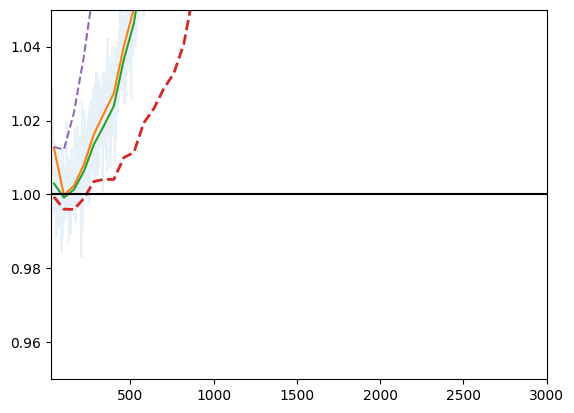

In [131]:
plt.plot((np.split(total_qe_mean, Nf)[0]-n_gg-N1s_iter[0])/phi_input, alpha = 0.1)

el, x = itu.bin_theory((np.split(total_qe_mean, Nf)[0]-n_gg-N1s_iter[0]), bin_edges)
ii = itu.bin_theory(phi_input, bin_edges)[1]
plt.plot(el, x/ii)

el, x = itu.bin_theory((np.split(total_qe_mean, Nf)[0]-n_gg-N1), bin_edges)
ii = itu.bin_theory(phi_input, bin_edges)[1]
plt.plot(el, x/ii)

el, x = itu.bin_theory((np.split(difference, Nf)[0]), bin_edges)
ii = itu.bin_theory(phi_input, bin_edges)[1]
plt.plot(el, x/ii, lw = 2, ls = "--")

el, x = itu.bin_theory((np.split(total_qe_mean, Nf)[0]-n_gg), bin_edges)
ii = itu.bin_theory(phi_input, bin_edges)[1]
plt.plot(el, x/ii, ls = "--")

plt.hlines(1, 30, 5000, color = "black")
plt.ylim(0.95, 1.05)

plt.xlim(20, 3000)

/tmp/ipykernel_14881/1473697388.py:1: RuntimeWarning: invalid value encountered in divide
  ff = r_gg_fid_3/r_gg_fid
/tmp/ipykernel_14881/1473697388.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.split(total_qe_cross_mean, 2)[0]/phi_input, alpha = 0.2)


(0.99, 1.01)

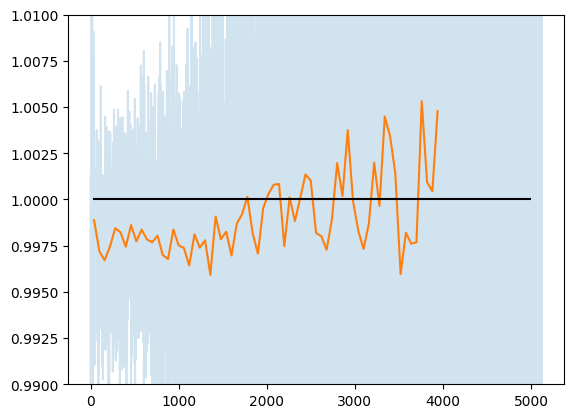

In [155]:
ff = r_gg_fid_3/r_gg_fid

el, x = itu.bin_theory(ff*np.split(total_qe_cross_mean, 2)[0], bin_edges)
ii = itu.bin_theory(phi_input, bin_edges)[1]

plt.plot(np.split(total_qe_cross_mean, 2)[0]/phi_input, alpha = 0.2)
plt.plot(el, x/ii)

el, x = itu.bin_theory(np.split(total_qe_cross_mean, 2)[1], bin_edges)
ii = itu.bin_theory(omega_input, bin_edges)[1]
plt.plot(el, x/ii, alpha = 0.3, ls = "--")

plt.hlines(1, 30, 5000, color = "black")
plt.ylim(0.99, 1.01)

## Compare reconstruction of $\phi$ from joint module vs baseline module

In [9]:
cmbversion = "phi_tau_joint_prova"

scratch = os.environ["SCRATCH"]+"/JOINTRECONSTRUCTION"
scratch_dir = f"{scratch}/{cmbversion}/"

dir = f"{scratch_dir}/simswalpha/"
phi = hp.read_alm(dir+"sim_0000_plm.fits").astype(np.complex128)
phi = utils.alm_copy(phi, lmax = 5120)

alpha = hp.read_alm(dir+"sim_0000_tau_lm.fits").astype(np.complex128)
alpha = utils.alm_copy(alpha, lmax = 5120)

In [54]:
version = "phi_tau_joint_prova_low"
its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/p_p_sim0000{version}/"

itrs = [0]
recs = rec()
directory_reconstruction = its_folder
plms = recs.load_plms(directory_reconstruction, itrs = itrs)

In [55]:
alpha_index = 0
phi_index = 1
omega_index = 2

indices = [alpha_index, phi_index, omega_index]

names = ["alpha", "phi", "omega"]
names = ["tau", "phi", "omega"]

fields_other = [phi, alpha, alpha]
fields = [alpha, phi, alpha]


ncomps = len(indices)

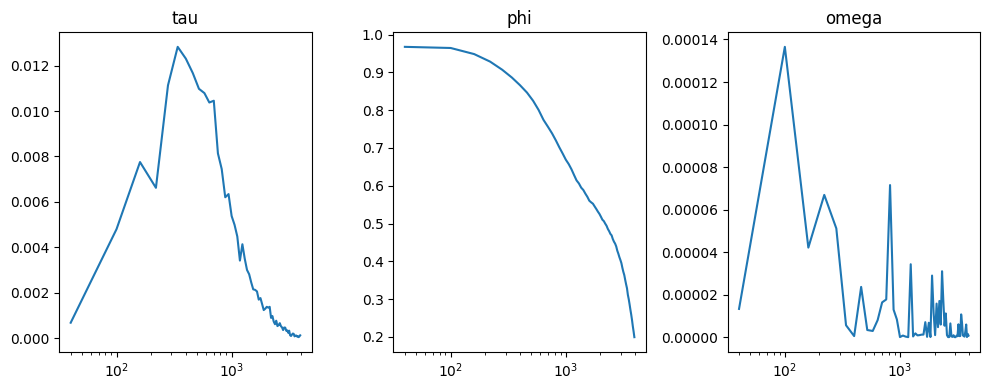

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = ncomps, figsize = (10, 4))

for index in indices:
    field = fields[index]
    field_other = fields_other[index]
    ax[index].set_title(names[index])
    for idx, itr in enumerate(itrs):
        p = np.split(plms[idx], ncomps)[index] if (plms[idx].size % ncomps == 0) else plms[idx]
        if idx == 0:
            xcorr = cross_corr_coeff(p, field, plot = False)
            xcorr_other = cross_corr_coeff(p, field_other, plot = False)

        cross_corr_coeff(p, field, base = 0, ax = ax[index])
        #cross_corr_coeff(p, field_other, base = 0, ax = ax[index])

    ax[index].set_xscale("log")
    
fig.tight_layout()

#cross_corr_coeff(alpha_both, alpha_both, base = 1, color = "black")
#plt.loglog(-hp.alm2cl(plms[0], -alpha_both))
#plt.loglog(-hp.alm2cl(plms[0]-diff, alpha_both))


In [58]:
#Check WF for alpha
index = 0 #alpha
idx = 0 # QE

Nsims = 8
mean_cross = 0
mean_alpha = 0

for simidx in range(Nsims):

    its_folder = f"{scratch}/{cmbversion}recs/p_p_sim{simidx:04}{version}/"
    plms = recs.load_plms(its_folder, itrs = [0])

    alpha = hp.read_alm(dir+f"sim_{simidx:04}_alpha_lm.fits").astype(np.complex128)
    alpha = utils.alm_copy(alpha, lmax = 5120)

    p = np.split(plms[idx], ncomps)[index]
    cross = -hp.alm2cl(p, alpha)
    auto_alpha = hp.alm2cl(alpha)

    mean_cross += cross
    mean_alpha += auto_alpha

mean_cross /= Nsims
mean_alpha /= Nsims

plt.plot(mean_cross/mean_alpha)
plt.plot(WF, lw = 2)
plt.xscale("log")

AssertionError: /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/phi_tau_joint_provarecs/p_p_sim0000phi_tau_joint_prova_low/phi_plm_it000.npy

In [101]:
blm = hp.read_alm("/scratch/snx3000/odarwish/alpha/simswalpha/"+"sim_0014_blm.fits")
elm = hp.read_alm("/scratch/snx3000/odarwish/alpha/simswalpha/"+"sim_0014_elm.fits")

In [65]:
dir = f"{scratch_dir}/simswalpha/"

from classy import Class

params = {
"output": "tCl,pCl,rCl",
"l_max_scalars": 4000 ,
"rotation": " yes ",
"alpha": 0. ,
"A_cb": 1e-7,
}

cosmo = Class()
cosmo.set(params)
cosmo.compute(level = ["rotation"])
cls = cosmo.rotated_cl()

In [99]:
params = {
    "output" : " tCl,pCl,rCl", #lCl, rCl" ,
    "l_max_scalars" : 4000,
    #"lensing": 'yes',
    "rotation": 'yes',
    "alpha" : 0.,
    "A_cb" : 1e-7,
    "omega_b" : 0.022445,
    "omega_cdm" : 0.1212,
    "h" : 0.67,
    "n_s" : 0.96,
    "A_s" : 2.1265e-09
}

cosmo = Class()
cosmo.set(params)
cosmo.compute(level=['rotation'])

raw_cls = cosmo.raw_cl()
#lensed_cls = cosmo.lensed_cl()
rotated_lensed_cls = cosmo.rotated_cl()

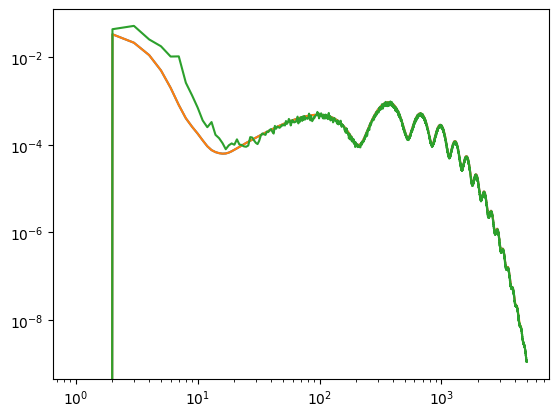

In [105]:
Tcmb = 2.72e6

bmode = False
key = "bb" if bmode else "ee"
x = blm if bmode else elm

plt.loglog(rotated_lensed_cls[key]*Tcmb**2)
#plt.loglog(lensed_cls["bb"])
plt.loglog(raw_cls[key]*Tcmb**2)
plt.plot(hp.alm2cl(x))